In [1]:
import cv2
import numpy as np
import glob
import json
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.dirname(os.path.abspath('.')))
import utils.frame_slicing as frame_slicing

number_of_squares_x = 11
number_of_internal_corners_x = number_of_squares_x - 1
number_of_squares_y = 8
number_of_internal_corners_y = number_of_squares_y - 1
square_size = 0.023 # in meters
cameras = ['cam2', 'cam3', 'wide', 'cam0', 'cam1']

In [2]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype("int32"))
    imgpts = imgpts.astype("int32")
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(10,9,0)
objp = np.zeros((number_of_internal_corners_x * number_of_internal_corners_y,3), np.float32)
objp[:,:2] = np.mgrid[0:number_of_internal_corners_x,0:number_of_internal_corners_y].T.reshape(-1,2)
objp = objp * square_size
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

In [4]:
def intrinsic_calibration(camera_name):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('screen_shots/*.png')

    shape = (0,0)

    effective_chessboard_count = 0
    total_chessboard_count = 0

    for fname in images:
        fname_parts = fname.split('/')[1].split('_')
        if fname_parts[0] != camera_name:
            continue
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        shape = gray.shape

        ret, corners = cv2.findChessboardCorners(gray, (number_of_internal_corners_x,number_of_internal_corners_y), None)
        # Corners: numpy array of shape (number_of_internal_corners, 1, 2)
        
        if ret == True:
            corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            objpoints.append(objp)
            imgpoints.append(corners)
            effective_chessboard_count += 1
            
        total_chessboard_count += 1

    if (effective_chessboard_count < 10):
        raise ValueError(f'Not enough effective chessboard found: {effective_chessboard_count}/{total_chessboard_count}')

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape[::-1], None, None)
    
    print(f'{camera_name} Effective Chessboard: {effective_chessboard_count}/{total_chessboard_count}')

    with open(f'results/intrinsic_{camera_name}.json', 'w') as f:
        json.dump({'mtx': mtx.tolist(), 'dist': dist.tolist()}, f)
        
    return mtx, dist

In [5]:
def extrinsic_calibration(mtxs, dists):

    images = glob.glob('screen_shots/*.png')

    effective_chessboard_count = 0
    total_chessboard_count = 0
    
    transformation_matrices = []

    for image in images:
        cameras_ret = True
        if len(image.split('/')[1].split('_')) != 1:
            continue
        
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(gray)
        frames = [frame1, frame2, frame3, frame4, frame5]
        
        transformation_matrix_temp = np.zeros((len(cameras), 4, 4))
        
        for camera in cameras:
            frame = frames[cameras.index(camera)]
            ret, corners = cv2.findChessboardCorners(frame, (number_of_internal_corners_x,number_of_internal_corners_y), None)
        
            if ret == True:
                corners = cv2.cornerSubPix(frame, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
                ret, rvec, tvec = cv2.solvePnP(objp, corners, mtxs[cameras.index(camera)], dists[cameras.index(camera)])
                
                imgpts, _ = cv2.projectPoints(objp, rvec, tvec, mtxs[cameras.index(camera)], dists[cameras.index(camera)])
                frame = draw(frame,corners,imgpts)
                cv2.imwrite(f'reprojection/img_f{image.split("/")[1]}_{camera}.png', frame)
                
                R, _ = cv2.Rodrigues(rvec)
                # The rvec and tvec are the object points in the camera coordinate system
                transformation_matrix_temp[cameras.index(camera), :3, :3] = R
                transformation_matrix_temp[cameras.index(camera), :3, 3] = tvec.T[0]
                transformation_matrix_temp[cameras.index(camera), 3, 3] = 1
                # Find the inverse matrix so we can find the object points of the camera relative to the chessboard
                transformation_matrix_temp[cameras.index(camera), :, :] = np.linalg.inv(transformation_matrix_temp[cameras.index(camera), :, :])
            else:
                cameras_ret = False
            
        if cameras_ret:
            transformation_matrices.append(transformation_matrix_temp)
            effective_chessboard_count += 1
        
        total_chessboard_count += 1
        
    print(f'Effective Chessboard: {effective_chessboard_count}/{total_chessboard_count}')
    transformation_matrices = np.array(transformation_matrices)
    # The transformation matrices are the transformation matrix from the chessboard to the camera
    return transformation_matrices

### Transformation Matrix

$$ H = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} 
    = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

In [6]:
def set_origin(transformation_matrices):
    for i in range(transformation_matrices.shape[0]):
        chess_board_transformation_matrix = np.linalg.inv(transformation_matrices[i, 2, :, :])
        transformation_matrices[i, 0, :, :] = transformation_matrices[i, 0, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 1, :, :] = transformation_matrices[i, 1, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 3, :, :] = transformation_matrices[i, 3, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 4, :, :] = transformation_matrices[i, 4, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 2, :, :] = np.zeros((4, 4))
        transformation_matrices[i, 2, 3, 3] = 1
    return transformation_matrices

In [7]:
def remove_outliers(transformation_matrices):
    # TODO: Remove outliers
    transformation_matrices = transformation_matrices[0, :, :, :]
    return transformation_matrices

In [8]:
def visualize(transformation_matrices):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    for i in range(len(transformation_matrices)):
        orientation = np.array([1, 0, 0]) @ transformation_matrices[i, :3, :3]
        ax.quiver(transformation_matrices[i, 3, 0], transformation_matrices[i, 3, 1], transformation_matrices[i, 3, 2], orientation[0], orientation[1], orientation[2], color = 'red', length=0.1)
        
    return fig

In [9]:
# images = glob.glob('screen_shots/*.png')

# for image in images:
#     image_name = image.split('/')[1]
#     img = cv2.imread(image)
#     frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(img)
#     cv2.imwrite(f"screen_shots/cam2_{image_name}", frame1)
#     cv2.imwrite(f"screen_shots/cam3_{image_name}", frame2)
#     cv2.imwrite(f"screen_shots/wide_{image_name}", frame3)
#     cv2.imwrite(f"screen_shots/cam0_{image_name}", frame4)
#     cv2.imwrite(f"screen_shots/cam1_{image_name}", frame5)

In [10]:
mtxs = np.zeros((len(cameras), 3, 3))
dists = np.zeros((len(cameras), 5))

for camera in cameras:
    mtx_cam, dist_cam = intrinsic_calibration(camera)
    mtxs[cameras.index(camera), :, :] = mtx_cam[0]
    dists[cameras.index(camera), :] = dist_cam[0]

cam2 Effective Chessboard: 29/48
cam3 Effective Chessboard: 34/48
wide Effective Chessboard: 46/48
cam0 Effective Chessboard: 28/48
cam1 Effective Chessboard: 23/48


In [11]:
transformation_matrices = extrinsic_calibration(mtxs, dists)

/var/folders/64/cy9kvd894_bfkfb71dsbxt2w0000gn/T/ipykernel_60670/348721601.py:3: RuntimeWarning: invalid value encountered in cast
  imgpts = imgpts.astype("int32")


Effective Chessboard: 3/48


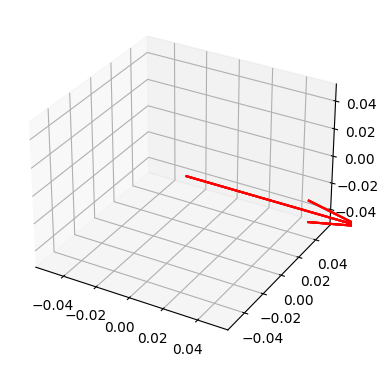

In [12]:
transformation_matrices = set_origin(transformation_matrices)
transformation_matrices = remove_outliers(transformation_matrices)
with open(f'results/extrinsic.json', 'w') as f:
    for i in range(transformation_matrices.shape[0]):
        json.dump(transformation_matrices[i].tolist(), f)
        f.write('\n')
fig = visualize(transformation_matrices)
plt.show()